# *Exploring the Application of Long Short Term Memory (LSTM) Neural Networks for 1-Day Prediction of Spread Series of Cointegrated Cryptocurrency Pairs*

**Goal:** To assess the applicability of LSTM neural networks in predicting the movement of cointegrated cryptocurrency pairs. 

**Question:** Can LSTM neural networks surpass the performance of a baseline persistence forecast model in terms of root mean squared error (RMSE)? 

**Motivation:** Pairs trading strategies can be divided into two categories: non-parametric and parametric. Non-parametric approaches do not explicitly model the time evolution of the spread series; for example, when the spread deviates by a certain amount above the mean, they sell the spread, and when the spread goes a certain amount below the mean, they buy the spread. No model is needed here. Parametric approaches attempt to make more precise predictions about the movement of the spread by modeling it explicitly - e.g., via an ARMA model. Here, we explore the possibility of a parametric approach that uses an LSTM model to predict the motion of the spread. 

**Expectations:** According to Brownlee's *Deep Learning for Time Series Forcasting*, the performance of LSTM networks on univariate time series data is not thought to surpass that of classical time series methods; they begin to shine primarily in the context of multivariate time series data. Nevertheless, one expects that they should be able to surpass the performance of a simple persistence model.

**Steps:**

-  Load Cryptocurrency data into pandas dataframe
-  Explore data: plot price movement, returns, correlations between returns
-  Find cointegrated crypto pairs and calculate spread
-  Test performance of baseline persistence forecast on one crypto pair
-  Train various LSTM models with different architectures and hyperparameters and test performance

# Import Data

Cryptocurrency price data taken from https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory/version/13

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Bitcoin = pd.read_csv('cryptocurrencypricehistory/bitcoin_price.csv')
Bitcoin_close = pd.Series(Bitcoin['Close'], name='Bitcoin_close')
Ethereum = pd.read_csv('cryptocurrencypricehistory/ethereum_price.csv')
Ethereum_close = pd.Series(Ethereum['Close'], name='Ethereum_close')
Litecoin = pd.read_csv('cryptocurrencypricehistory/litecoin_price.csv')
Litecoin_close = pd.Series(Litecoin['Close'], name='Litecoin_close')
Dash = pd.read_csv('cryptocurrencypricehistory/dash_price.csv')
Dash_close = pd.Series(Dash['Close'], name='Dash_close')
Monero = pd.read_csv('cryptocurrencypricehistory/monero_price.csv')
Monero_close = pd.Series(Monero['Close'], name='Monero_close')
Nem = pd.read_csv('cryptocurrencypricehistory/nem_price.csv')
Nem_close = pd.Series(Nem['Close'], name='Nem_close')
Ripple = pd.read_csv('cryptocurrencypricehistory/ripple_price.csv')
Ripple_close = pd.Series(Ripple['Close'], name='ripple_close')

#Assemble different price series into dataframe
Cryptos = pd.concat([Bitcoin_close, Ethereum_close, Litecoin_close, Dash_close, Monero_close, Nem_close, Ripple_close], axis=1, names=['Bitcoin', 'Ethereum', 'Litecoin', 'Dash', 'Monero', 'Nem', 'Ripple'])

#Find earliest date back to which price data exists for all columns
num_days =929 
Cryptos = Cryptos[0:num_days]

#Set datetime index
dates = pd.date_range(start='8/7/2015', end='2/20/2018')
dates = pd.Index(reversed(dates))
Cryptos = Cryptos.set_index(dates)

Using TensorFlow backend.


# Data Exploration

In [2]:
Cryptos.head()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2018-02-20,11403.7,895.37,232.85,685.04,304.40,0.484397,1.09
2018-02-19,11225.3,943.87,223.06,728.73,316.49,0.529261,1.14
2018-02-18,10551.8,923.92,215.74,689.28,300.12,0.530407,1.12
2018-02-17,11112.7,974.12,229.47,742.16,325.67,0.598880,1.20
2018-02-16,10233.9,944.21,230.12,698.86,296.48,0.568887,1.14


In [3]:
Cryptos.tail()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2015-08-11,270.39,1.070000,4.16,3.16,0.603582,0.000135,0.008591
2015-08-10,264.47,0.708448,3.95,3.08,0.656576,0.000135,0.008750
2015-08-09,265.08,0.701897,3.90,3.11,0.674739,0.000130,0.008808
2015-08-08,261.00,0.753325,3.85,3.08,0.676046,0.000136,0.008476
2015-08-07,279.58,2.770000,4.21,3.26,0.742292,0.000145,0.008152


In [4]:
Cryptos.describe()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,2480.192842,147.784327,32.648611,146.184101,48.952522,0.125104,0.167626
std,3802.251587,264.130846,62.084714,268.316629,93.518276,0.269597,0.415997
min,210.500000,0.434829,2.630000,2.060000,0.366891,0.000086,0.004090
25%,435.120000,7.910000,3.610000,6.230000,0.910537,0.001365,0.006291
50%,735.600000,12.020000,3.970000,11.450000,8.420000,0.005415,0.007758
75%,2589.600000,245.990000,42.240000,178.510000,45.020000,0.182819,0.194124
max,19497.400000,1396.420000,358.340000,1550.850000,469.200000,1.840000,3.380000


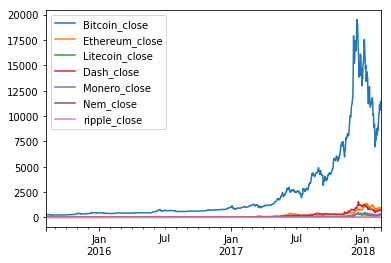

In [5]:
Cryptos = Cryptos[::-1] #To get time increasing from left to right in plot
Cryptos.plot()

Zoom in on more right part where there seems to be more activity. 

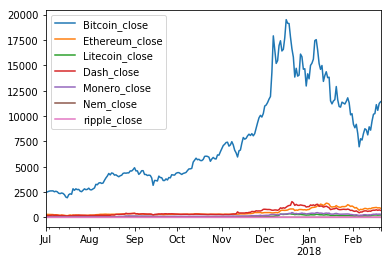

In [6]:
Cryptos_trunc = Cryptos['2017-07-1':'2018-02-20']
Cryptos_trunc.plot()

Divide series by their initial values to facilitate comparison.

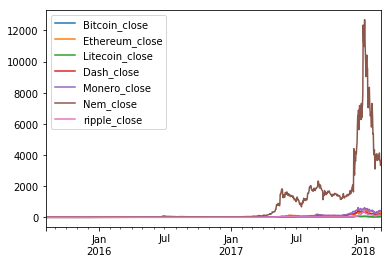

In [7]:
Cryptos_norm = Cryptos/Cryptos.iloc[0]
Cryptos_norm.plot()

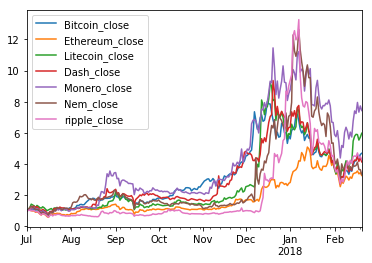

In [8]:
Cryptos_trunc_norm = Cryptos_trunc/Cryptos_trunc.iloc[0]
Cryptos_trunc_norm.plot()

**Observations:** Strong co-movement of crypto price series. Suggests suitability for cointegration. In mid-December 2017, there is a large jump in all cryptos. What event might have caused this?

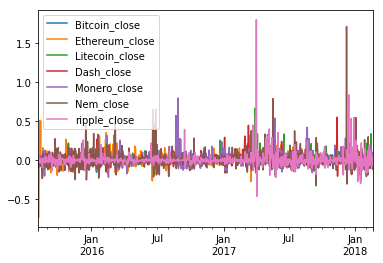

In [9]:
# Calculate returns
Cryptos_returns = Cryptos.pct_change()

#Plot returns
Cryptos_returns.plot()

**Observations:** Volatility shifts a lot over time.

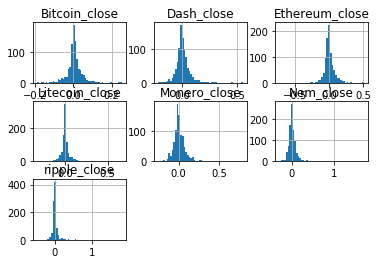

In [10]:
Cryptos_returns.hist(bins=50)
Cryptos_returns = Cryptos_returns.dropna()

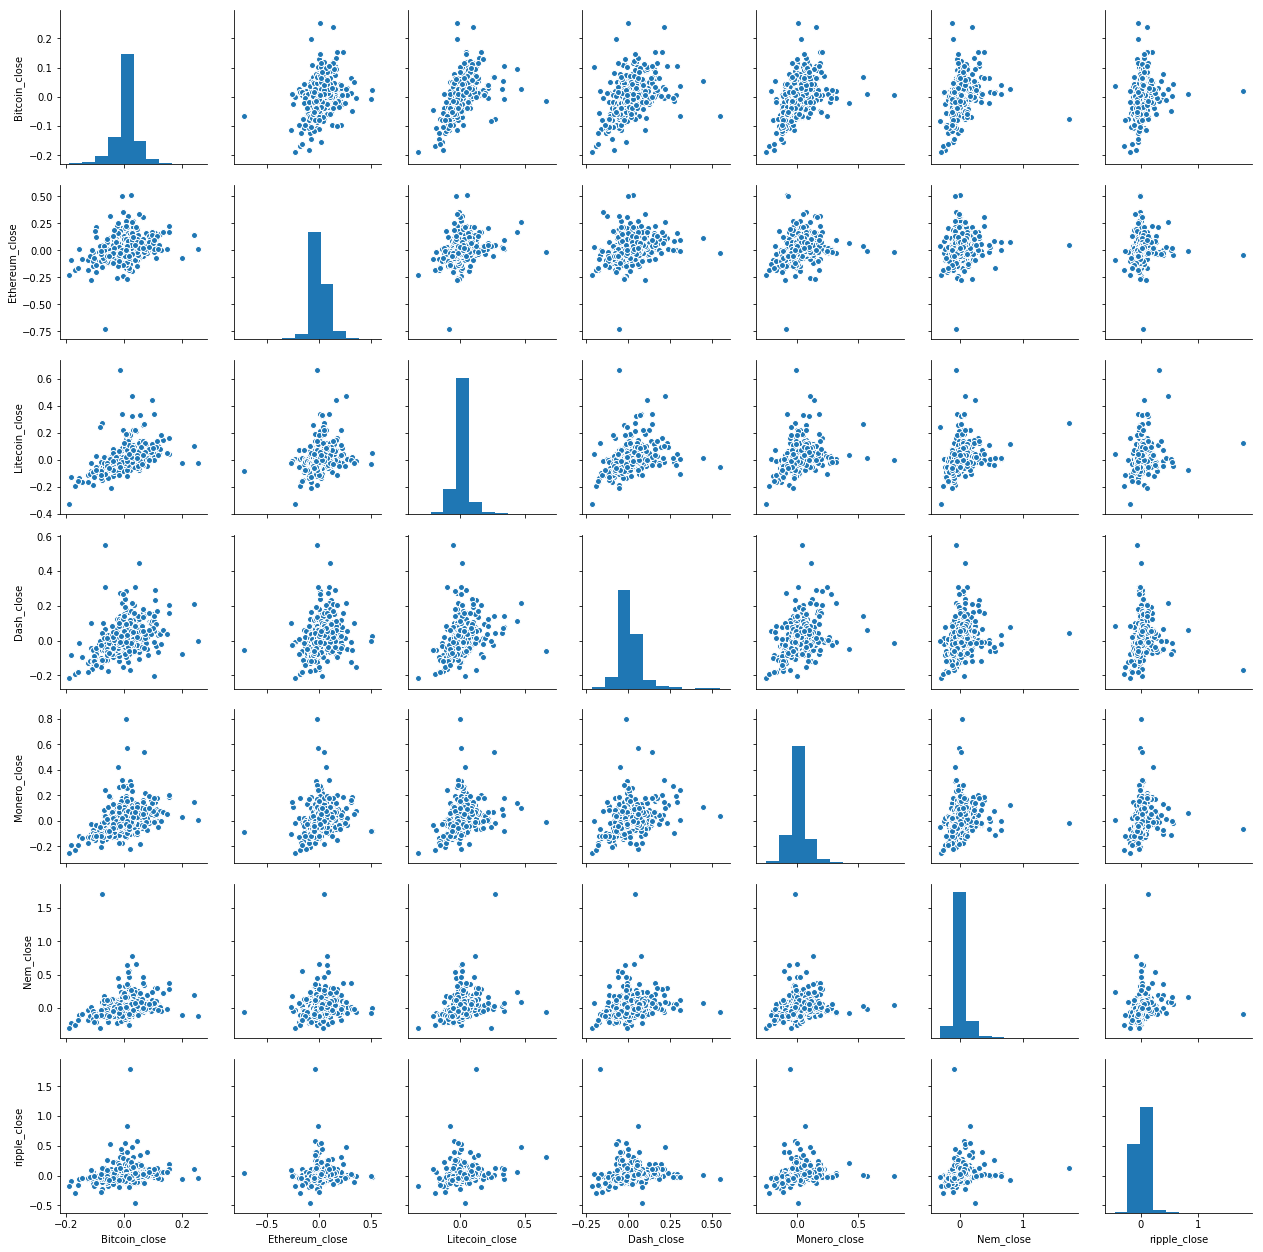

In [11]:
import seaborn as sns

sns.pairplot(Cryptos_returns);

**Observations:** Strong correlations between returns of different pairs of cryptos - e.g., Bitcoin/Litecoin, Monero/Bitcoin

# Impose Train-Test Split

For training LSTM, train set must be evenly divisible by batch size. Make train_size evenly divisible number to facilitate many possible choices of batch size in training. 

In [12]:
X = Cryptos.values
n_obs = len(X)
#train_size = int(n_obs * 0.9)
train_size = 800 
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
Cryptos.reindex(index=Cryptos.index[::-1])
Cryptos_train = Cryptos[:train_size]
Cryptos_test = Cryptos[train_size:]

Observations: 929
Training Observations: 800
Testing Observations: 129


In [13]:
Cryptos_train.shape

(800, 7)

In [14]:
Cryptos_test.shape

(129, 7)

In [15]:
Cryptos_train.head()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2015-08-07,279.58,2.770000,4.21,3.26,0.742292,0.000145,0.008152
2015-08-08,261.00,0.753325,3.85,3.08,0.676046,0.000136,0.008476
2015-08-09,265.08,0.701897,3.90,3.11,0.674739,0.000130,0.008808
2015-08-10,264.47,0.708448,3.95,3.08,0.656576,0.000135,0.008750
2015-08-11,270.39,1.070000,4.16,3.16,0.603582,0.000135,0.008591


In [16]:
Cryptos_train.tail()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2017-10-10,4781.99,299.87,50.72,291.27,86.82,0.209909,0.260733
2017-10-11,4826.48,303.46,50.89,298.40,87.42,0.214811,0.264439
2017-10-12,5446.91,304.14,60.11,291.91,87.09,0.206147,0.248414
2017-10-13,5647.21,338.76,59.43,310.38,95.13,0.211569,0.260489
2017-10-14,5831.79,339.63,63.95,316.69,100.23,0.210581,0.257320


In [17]:
Cryptos_test.head()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2017-10-15,5678.19,336.60,65.47,309.51,94.87,0.207300,0.263983
2017-10-16,5725.59,333.38,64.62,302.21,95.90,0.223181,0.256232
2017-10-17,5605.51,317.08,59.48,299.88,91.28,0.218207,0.232064
2017-10-18,5590.69,314.32,60.73,297.26,89.54,0.220316,0.218520
2017-10-19,5708.52,308.09,59.74,295.47,88.62,0.220531,0.215150


In [18]:
Cryptos_test.tail()

,Bitcoin_close,Ethereum_close,Litecoin_close,Dash_close,Monero_close,Nem_close,ripple_close
2018-02-16,10233.9,944.21,230.12,698.86,296.48,0.568887,1.14
2018-02-17,11112.7,974.12,229.47,742.16,325.67,0.598880,1.20
2018-02-18,10551.8,923.92,215.74,689.28,300.12,0.530407,1.12
2018-02-19,11225.3,943.87,223.06,728.73,316.49,0.529261,1.14
2018-02-20,11403.7,895.37,232.85,685.04,304.40,0.484397,1.09


Put test set aside. Focus on training data.

### Examine Training Data

Divide each price series by its initial value to facilitate comparison of price movements.

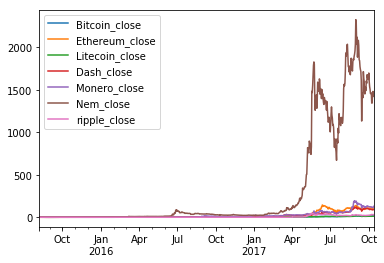

In [19]:
Cryptos_train_norm = Cryptos_train/Cryptos_train.iloc[0]
Cryptos_train_norm.plot()

**Observations:** Nem has very strong cumulative returns. In the bottom right corner of the plot, there appears to be a lot of co-movement. Zoom in on this. 

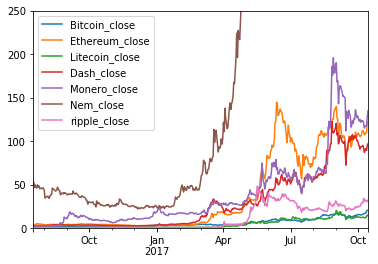

In [20]:
Cryptos_train_norm.plot(xlim=('2016-07-17','2017-10-14'), ylim=(0,250))

**Observations:** Patterns in the price movement appear to change qualitatively around April  2017. One idea is to train on data after this date (not done below).

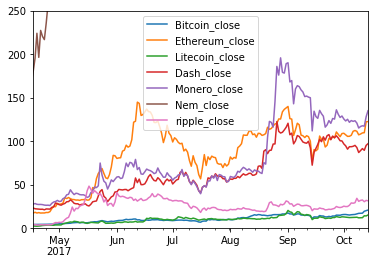

In [21]:
Cryptos_train_norm.plot(xlim=('2017-04-17','2017-10-14'), ylim=(0,250))

# Find Cointegrated Series, Compute the Spread, Test for Stationarity

Code adapted from https://www.quantopian.com/lectures/introduction-to-pairs-trading.

In [22]:
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.001:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

/Users/jrosaler/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(Cryptos_train)

In [24]:
score_matrix

array([[  0.00000000e+00,  -1.65232439e+00,  -2.91271762e+00,
         -4.05039811e+00,  -4.88841340e+00,   2.99146629e-04,
         -7.24545641e-01],
       [  0.00000000e+00,   0.00000000e+00,  -6.28563525e+00,
         -3.89012568e+00,  -3.33461078e+00,  -6.23039729e+00,
         -4.09982825e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -2.90230118e+00,  -3.14028033e+00,  -5.38490019e+00,
         -2.57998085e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -4.27807513e+00,  -2.83077643e+00,
         -1.95933742e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -2.56490520e+00,
         -2.33730254e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -2.88924182e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00

In [25]:
pvalue_matrix

array([[  1.00000000e+00,   6.98308024e-01,   1.32436899e-01,
          6.07813179e-03,   2.62664144e-04,   9.85907205e-01,
          9.43923971e-01],
       [  1.00000000e+00,   1.00000000e+00,   3.83293552e-07,
          1.02349719e-02,   5.01500028e-02,   5.08611067e-07,
          5.14768774e-03],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.35291970e-01,   8.04955355e-02,   3.03797490e-05,
          2.44977715e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   2.76941029e-03,   1.56088522e-01,
          5.49639337e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.51217688e-01,
          3.55094282e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.38933365e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00

In [26]:
pairs

[('Bitcoin_close', 'Monero_close'),
 ('Ethereum_close', 'Litecoin_close'),
 ('Ethereum_close', 'Nem_close'),
 ('Litecoin_close', 'Nem_close')]

# Check for Stationarity

Code adapted from https://www.quantopian.com/lectures/integration-cointegration-and-stationarity

p-value = 4.037278103e-07 The series Bitcoin_close/Monero_close spread is likely stationary.


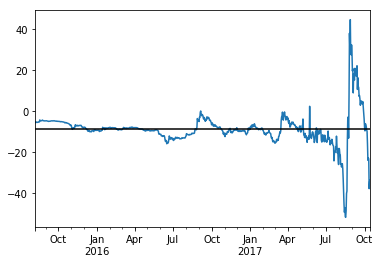

p-value = 8.42014509346e-09 The series Ethereum_close/Litecoin_close spread is likely stationary.


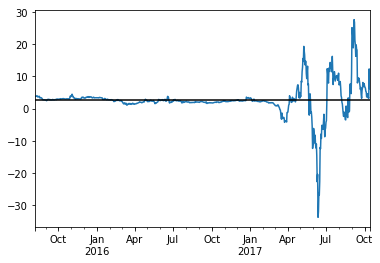

p-value = 2.30227481647e-09 The series Ethereum_close/Nem_close spread is likely stationary.


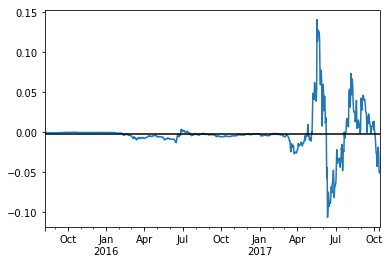

p-value = 6.20826943592e-07 The series Litecoin_close/Nem_close spread is likely stationary.


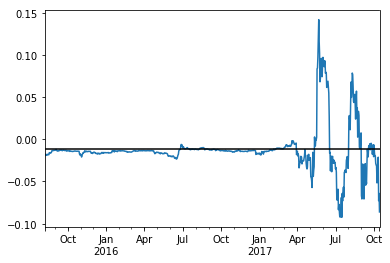

In [27]:
def check_for_stationarity(X, cutoff=0.001):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + str(X.name) +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + str(X.name) +' is likely non-stationary.')
        return False

spreads_train = [] #Collect spreads of cointegrated pairs in training set
spreads_train_OLSparams = []

for pair in pairs:
    S1 = Cryptos_train[pair[0]]
    S2 = Cryptos_train[pair[1]]
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[pair[0]]
    b = results.params[pair[0]]

    spread = S2 - b * S1
    spread.name = pair[0] + '/' + pair[1] + ' spread'
    if check_for_stationarity(spread):
        spreads_train.append(spread)
        spreads_train_OLSparams.append(results)
        
    spread.plot()
    plt.axhline(spread.mean(), color='black')
    plt.show()
    
    

**Observation:** Lots of volatility in all the spreads starting at around April 2017. What happened at this time? Note also that volatility occurs across pairs that do not share a single crypto label - e.g. across Bitcoin/Monero and Ethereum/Litecoin. 

Check spreads in spreads_train, and parameters in spreads_train_OLSparams:

In [28]:
#DATA PREPARATION
#-----------------------------------------------------------------------------------------------------------------
#Check spreads_train
for spread in spreads_train:
    print(spread.name)

#Check spreads_train
for results in spreads_train_OLSparams:
    print(results.params[0], results.params[1])  

#Use Ethereum Litecoin spread, called spreads[]
spread_train_EL = spreads_train[1]

Bitcoin_close/Monero_close spread
Ethereum_close/Litecoin_close spread
Ethereum_close/Nem_close spread
Litecoin_close/Nem_close spread
-8.83504772781 0.0229645286619
2.69404132329 0.157314049108
-0.00200413266628 0.000769941085293
-0.0120331397842 0.00464095645024


[('Bitcoin_close', 'Monero_close'), ('Ethereum_close', 'Litecoin_close'), ('Ethereum_close', 'Nem_close'), ('Litecoin_close', 'Nem_close')]


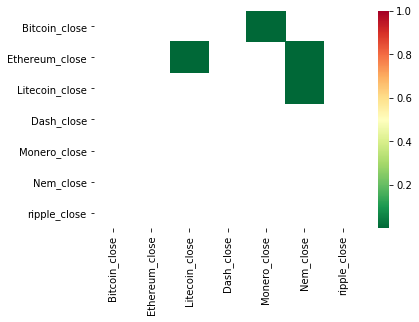

In [29]:
import seaborn
seaborn.heatmap(pvalue_matrix, xticklabels=Cryptos_train.columns, yticklabels=Cryptos_train.columns, cmap='RdYlGn_r' 
                , mask = (pvalue_matrix >= 0.001)
                )
print(pairs)

Color indicates strength of the cointegration relationship. Ethereum/Litecoin has smallest p-value. 

In [30]:
score, pvalue, _ = coint(Cryptos_train['Ethereum_close'], Cryptos_train['Litecoin_close'])
pvalue, score

(3.8329355160488153e-07, -6.2856352475337172)

# Transform Ethereum-Litecoin Spread to Supervised Format, and Scale Data for Input into LSTM 

Spread series data already stationary, so no need for differencing. Just convert to supervised format and scale data.

In [60]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.preprocessing import MinMaxScaler

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

#Compute Ethereum-Litecoin spread on full data set using OLS parameters found from regression on training set.
U1 = Cryptos['Ethereum_close']
U2 = Cryptos['Litecoin_close']
b = spreads_train_OLSparams[1].params['Ethereum_close']
spread_EL = U2 - b*U1


#UNSMOOTHED DATA
# split into train and test
train = spread_EL.values[:train_size]
test = spread_EL.values[train_size:]

# transform data for supervised learning
window = 100
supervised = timeseries_to_supervised(spread_EL.values, window)

# split supervised data into train and test-sets
train_supervised, test_supervised = supervised_values[0:train_size], supervised_values[train_size:]

# transform the scale of the data for LSTM
scaler, train_supervised_scaled, test_supervised_scaled = scale(train_supervised, test_supervised)



#SMOOTHED DATA
#We want to train on the smoothed data and test on the non-smoothed test set.

#smooth full data set
spread_EL_smoothed = pd.rolling_mean(spread_EL, 5)

# transform smoothed data for supervised learning
window = 100
supervised_smoothed = timeseries_to_supervised(spread_EL_smoothed.values, window)
supervised_smoothed = supervised_smoothed.values

print("supervised_smoothed.shape: " + str(supervised_smoothed.shape))
print("supervised_smoothed[0:10]: " + str(supervised_smoothed[0:10]))

#split smoothed set into train test
train_supervised_smoothed = supervised_smoothed[:train_size]
test_supervised_smoothed = supervised_smoothed[train_size:]
print("train_supervised_smoothed.shape: " + str(train_supervised_smoothed.shape))

# transform the scale of the smoothed data for LSTM
scaler, train_supervised_smoothed_scaled, test_supervised_smoothed_scaled = scale(train_supervised_smoothed, test_supervised_smoothed)

#split smoothed train set into X, y
train_supervised_smoothed_scaled_X = train_supervised_smoothed_scaled[:,0:-1]
train_supervised_smoothed_scaled_y = train_supervised_smoothed_scaled[:,-1]


print("train_supervised_smoothed_scaled_X.shape: " + str(train_supervised_smoothed_scaled_X.shape))
print("train_supervised_smoothed_scaled_y.shape: " + str(train_supervised_smoothed_scaled_y.shape))
print("train_supervised_smoothed_scaled_X[0:10]: " + str(train_supervised_smoothed_scaled_X[0:10]))
print("train_supervised_smoothed_scaled_y[0:10]: " + str(train_supervised_smoothed_scaled_y[0:10]))



supervised_smoothed.shape: (929, 101)
supervised_smoothed[0:10]: [[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 3.80199981  3.82987503  3.82510767 ...,  0.          0.          3.79250652]
 [ 3.79250652  3.80199981  3.82987503 ...,  0.          0.          3.75762413]
 [ 3.75762413  3.79250652  3.80199981 ...,  0.          0.          3.69989273]]
train_supervised_smoothed.shape: (800, 101)
train_supervised_smoothed_scaled_X.shape: (800, 100)
train_supervised_smoothed_scaled_y.shape: (800,)
train_supervised_smoothed_scaled_X[0:10]: [[ 0.09257214  0.09257214  0.09257214  0.09257214  0.09257214  0.09257214
   0.09257214  0.09257214  0.09257214  0.09257214  0.09257214  0.09257214
   0.09257214  0.09257214  0.09257214  0.09257214  0.09257214  0.09257214
   0.09257214  0.09257214  0.09257214

/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


(800,)


# Baseline Model: Persistence Forecast of Ethereum-Litecoin Spread

Code adapted from https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

RMSE: 14.353


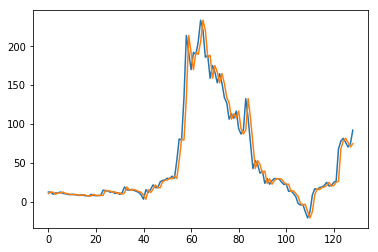

In [64]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])
# report performance
#print(predictions)
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()


**The number to beat:**  RMSE = 14.353

# Train LSTM Model for 1-Day Forecast of Ethereum-Litecoin Spread; Evaluate RMSE on Test Set

/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


Epoch 1/1
 - 6s - loss: 0.0702
Epoch 1/1
 - 2s - loss: 0.0557
Epoch 1/1
 - 2s - loss: 0.0442
Epoch 1/1
 - 2s - loss: 0.0453
Epoch 1/1
 - 2s - loss: 0.0409
Epoch 1/1
 - 2s - loss: 0.0408
Epoch 1/1
 - 2s - loss: 0.0411
Epoch 1/1
 - 2s - loss: 0.0403
Epoch 1/1
 - 2s - loss: 0.0393
Epoch 1/1
 - 2s - loss: 0.0394
Saved model to disk


/Users/jrosaler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Month=1, Predicted=14.058794, Expected=12.174642
Month=2, Predicted=13.450006, Expected=9.598861
Month=3, Predicted=10.629678, Expected=11.283048
Month=4, Predicted=12.088094, Expected=11.273115
Month=5, Predicted=11.887464, Expected=12.504956
Month=6, Predicted=12.976692, Expected=10.975896
Month=7, Predicted=11.355691, Expected=10.331564
Month=8, Predicted=10.657850, Expected=9.778734
Month=9, Predicted=10.043199, Expected=9.028500
Month=10, Predicted=9.235755, Expected=9.621425
Month=11, Predicted=9.808416, Expected=9.091665
Month=12, Predicted=9.285928, Expected=8.541656
Month=13, Predicted=8.733734, Expected=8.077847
Month=14, Predicted=8.269675, Expected=9.115057
Month=15, Predicted=9.302471, Expected=7.976601
Month=16, Predicted=8.156949, Expected=7.630779
Month=17, Predicted=7.803525, Expected=7.293065
Month=18, Predicted=7.444749, Expected=9.523223
Month=19, Predicted=9.648517, Expected=8.087522
Month=20, Predicted=8.178857, Expected=7.771848
Month=21, Predicted=7.805399, Expe

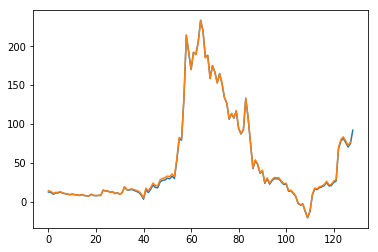

In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Activation, Dropout


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, layers):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(layers[0], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(layers[1],return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim=layers[2]))
    model.add(Activation("linear"))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, row):
    row = row.reshape(1, len(row), 1)
    yhat = model.predict(row, batch_size=batch_size)
    return yhat[0 ,0]


#MODEL FITTING AND STATE BUILDING
#-----------------------------------------------------------------------------------------------------------------
# parameters for fitting the model
num_epochs = 10
batch_size = 200
layers = (64, 32, 1) #number of neurons in each layer of lstm model

# fit the model
lstm_model = fit_lstm(train_supervised_smoothed_scaled, batch_size, num_epochs, layers)

# save the model weights and architecture to file
# serialize model to JSON
lstm_model_json = lstm_model.to_json()
with open("lstm_model_layers" + str(layers[0]) + ", " + str(layers[1]) + ", " + str(layers[2]) + ".json", "w") as json_file:
    json_file.write(lstm_model_json)
# serialize weights to HDF5
lstm_model.save_weights("model_epochs" + str(num_epochs) + "_batch" + str(batch_size) + "_layers" + str(layers[0]) + ", " + str(layers[1]) + ", " + str(layers[2]) + ".h5")
print("Saved model to disk")

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled.reshape(len(train_supervised_scaled), window + 1, 1)
lstm_model.predict(train_reshaped[:,:-1], batch_size=batch_size)


#COPY WEIGHTS OF FITTED LSTM_MODEL TO ENABLE DIFFERENT BATCH SIZES BETWEEN TRAINING AND PREDICTION
#-----------------------------------------------------------------------------------------------------------------
old_weights = lstm_model.get_weights()

# re-define batch size for prediction with model
batch_size_pred = 1

# use same architecture as in model defined in fit_lstm
new_model = Sequential()
new_model.add(LSTM(layers[0], batch_input_shape=(batch_size_pred, train_reshaped.shape[1] - 1, train_reshaped.shape[2]), stateful=False, return_sequences=True))
new_model.add(Dropout(0.2))
new_model.add(LSTM(layers[1], return_sequences=False))
new_model.add(Dropout(0.2))
new_model.add(Dense(output_dim=layers[2]))
new_model.add(Activation("linear"))
new_model.add(Dense(1))

new_model.compile(loss='mean_squared_error', optimizer='adam')
new_model.set_weights(old_weights) 

#EVALUATE TRAINED MODEL ON TEST DATA
#-----------------------------------------------------------------------------------------------------------------
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X_i, y_i = test_scaled[i, 0:-1], test_supervised_scaled[i, -1]
    yhat = forecast_lstm(new_model, 1, X_i)
    # invert scaling
    yhat = invert_scale(scaler, X_i, yhat)
    # invert differencing
    yhat = inverse_difference(spread_EL.values, yhat, len(test_supervised_scaled) + 1 - i)
    # store forecast
    predictions.append(yhat)
    expected = spread_EL.values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % ( i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(spread_EL.values[train_size + 1:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(spread_EL.values[train_size:])
pyplot.plot(predictions)
pyplot.show()



Test RMSE: 14.243. Just beats persistence forecast. 

## Also Tried
-  Decreasing size of training set to include only period of volatility - hope was that this would help the LSTM better capture the nature of the evolution extending into the test set. 
-  Stacked LSTM

Neither improved performance very significantly. 

## Ideas for Further Exploration

-  Try early stopping, using validation sets
-  Try stateless LSTMs to compare performance
-  Try larger time window

## ARIMA Model

This is a preliminary test of the ARIMA model on the spread series. A grid search of orders p,d,q of the ARIMA(p,d,q) model was performed on the test set. A more comprehensive analysis would performed time series cross validation on the ARIMA model, as was done for the LSTM.  

In [65]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Plot ACF and PACF functions to estimate appropriate order of ARIMA model.

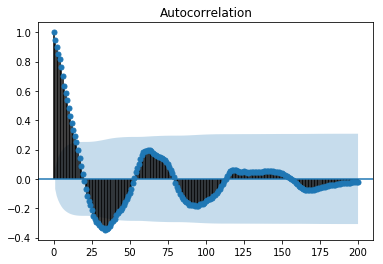

In [66]:
plot_acf(train, lags=200);

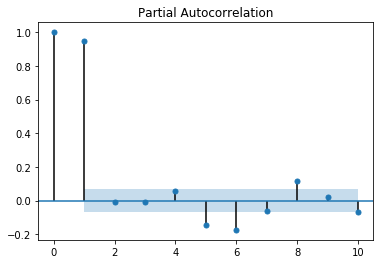

In [67]:
plot_pacf(train, lags=10);

Non-zero PACF for lag=1, but zero (effectively) for larger lags is consistent with an ARIMA(1,0,0) model.

In [68]:
import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, train_frac):
    # prepare training dataset
    train_size = int(len(X) * train_frac)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, train_frac):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order, train_frac)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = spread_EL #check this; maybe just use train
# evaluate parameters
p_values = range(0, 10)
d_values = [0, 1] #range(0, 3)
q_values = range(0, 3)
train_frac = float(800/929)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values, train_frac)

ARIMA(0, 0, 0) RMSE=75.486
ARIMA(0, 0, 1) RMSE=42.311
ARIMA(0, 1, 0) RMSE=14.359
ARIMA(0, 1, 1) RMSE=15.047
ARIMA(0, 1, 2) RMSE=15.559
ARIMA(1, 0, 0) RMSE=14.352
ARIMA(1, 1, 0) RMSE=15.720
ARIMA(2, 1, 0) RMSE=16.373
ARIMA(3, 1, 0) RMSE=16.122
ARIMA(4, 1, 0) RMSE=16.263
ARIMA(5, 1, 0) RMSE=16.649
ARIMA(6, 1, 0) RMSE=16.805
ARIMA(7, 1, 0) RMSE=17.162
Best ARIMA(1, 0, 0) RMSE=14.352


Best Score: RMSE=14.352 for ARIMA(1,0,0). 